# Forecasting of Retail Sales:

One our cousins in the spanish country have a grocery stores company which works in some villages in La Mancha. He have heard in the news something about the Machine Learning and its posibilities. Since he knows that we work as Data Scientist he has porpuse us to see if we can make a prediction in one of their products and we have accepted the offer. 

Our idea is to apply a couple of ML models and chechk if we can give him a good prediction of the sales of one of his products.

In [417]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler

from model_evaluation import calculoEvaluacionModelo, rmsle


fig_size = (29, 12)
norma = False

In [418]:
def rmsle(ytrue, ypred):


    return np.sqrt(mean_squared_log_error(ytrue, ypred))

def calculoEvaluacionModelo(modelo,df,norm):

    xPredicted = []
    yPredicted = []
    ySpotted = []
    mean_error = []

    for day in range(759,829):
        train = df[df['OffsetDays'] < day]
        val = df[df['OffsetDays'] == day]       
        
        xtr, xts = train.drop(['Unidades'], axis=1), val.drop(['Unidades'], axis=1)
        
        if(norm==True):
            sc = StandardScaler()  
            xtr = sc.fit_transform(xtr)  
            xts = sc.transform(xts)  
        ytr, yts = train['Unidades'].values, val['Unidades'].values  

        mdl = modelo
        mdl.fit(xtr, ytr)

        p = mdl.predict(xts)

        xPredicted=xPredicted + [day]
        yPredicted=yPredicted + [p[0]]
        ySpotted = ySpotted + [yts[0]]

        error = rmsle(yts, p)
        print('Month %d - Error %.5f' % (day, error))
        mean_error.append(error)
    return mean_error

    print('Mean Error = %.5f' % np.mean(mean_error))
    prediction = pd.DataFrame(
        {'Sold units predicted': yPredicted,
         'Sold units actually spotted': ySpotted
        },index=xPredicted)
    prediction.plot()

In [419]:
df = pd.read_csv('Dataframe_Retail.csv', parse_dates=['Fecha'])
df.head(10)

,Fecha,Referencia,Unidades,Ventas
0,2017-01-01,Cerveza tercio,18.000000,11.700000
1,2017-01-01,Baguetes 2 unidades,34.000000,33.320001
2,2017-01-02,Aceite de oliva virgen extra 5 l,53.000000,1184.550020
3,2017-01-02,Bolsa naranjas 2Kg.,1118.000000,1889.420064
4,2017-01-02,Mandarina,1752.468997,3356.279999
5,2017-01-02,Melo OR,399.428999,728.429999
6,2017-01-02,Baguetes 2 unidades,3572.000000,3257.839944
7,2017-01-02,Jamón reserva,48.515000,870.689999
8,2017-01-02,Cerveza tercio,1280.000000,802.150005
9,2017-01-02,Naranja en cajas,831.050001,1470.350000


## Data Analysis

What we can find in the dataframe is the sells of the each product each day and the money earned by the sale.

In [420]:
df['Referencia'].unique(), df['Referencia'].unique().shape

(array(['Cerveza tercio', 'Baguetes 2 unidades',
        'Aceite de oliva virgen extra 5 l', 'Bolsa naranjas 2Kg.',
        'Mandarina', 'Melo  OR', 'Jamón reserva', 'Naranja en cajas',
        'Pack de plátanos', 'MERLUZA PALANGRE 1 - 2 Kg (1 Caja 10Q.)',
        'Tomate jugoso al peso', 'Filetes de salmón', 'Sepia',
        'Fresa premium 500gr'], dtype=object),
 (14,))

* We have fourteen different products that the grocery store have in sales, so we will choose one in order to make the prediction. As good spaniards we choose iberian jam (_"Jamón reserva"_). As we can see this parameter is a float64, so the ham can be sold not for units (kg for the ham) but also fractions of the units.

In [421]:
df = df.loc[df['Referencia'] == 'Jamón reserva'].\
    drop('Referencia', axis = 1).\
    set_index('Fecha')

In [422]:
df.head()

,Unidades,Ventas
Fecha,,
2017-01-02,48.515,870.689999
2017-01-03,63.325,1136.559994
2017-01-04,42.230,922.829997
2017-01-05,58.165,1273.139998
2017-01-07,71.330,1561.350001


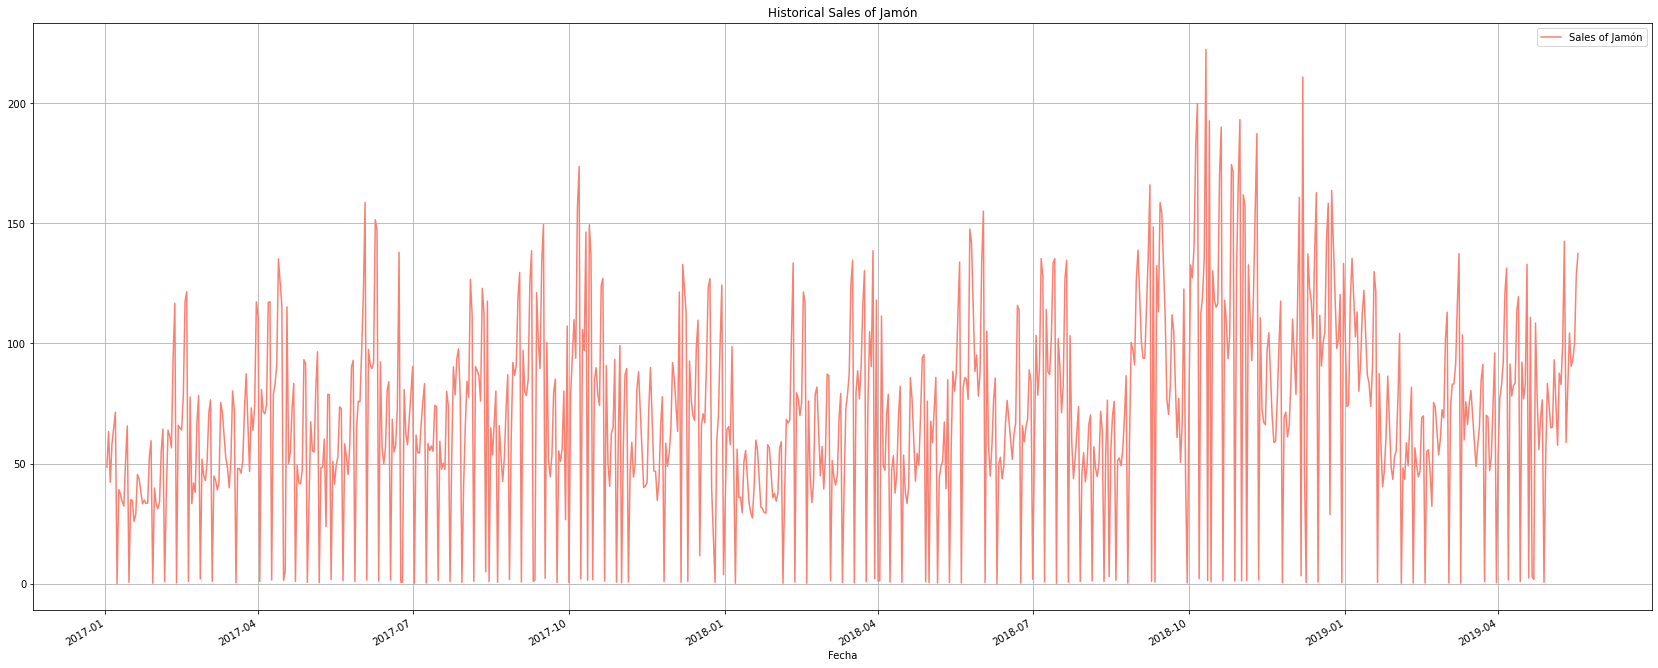

In [423]:
df['Unidades'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Historical Sales of Jamón');

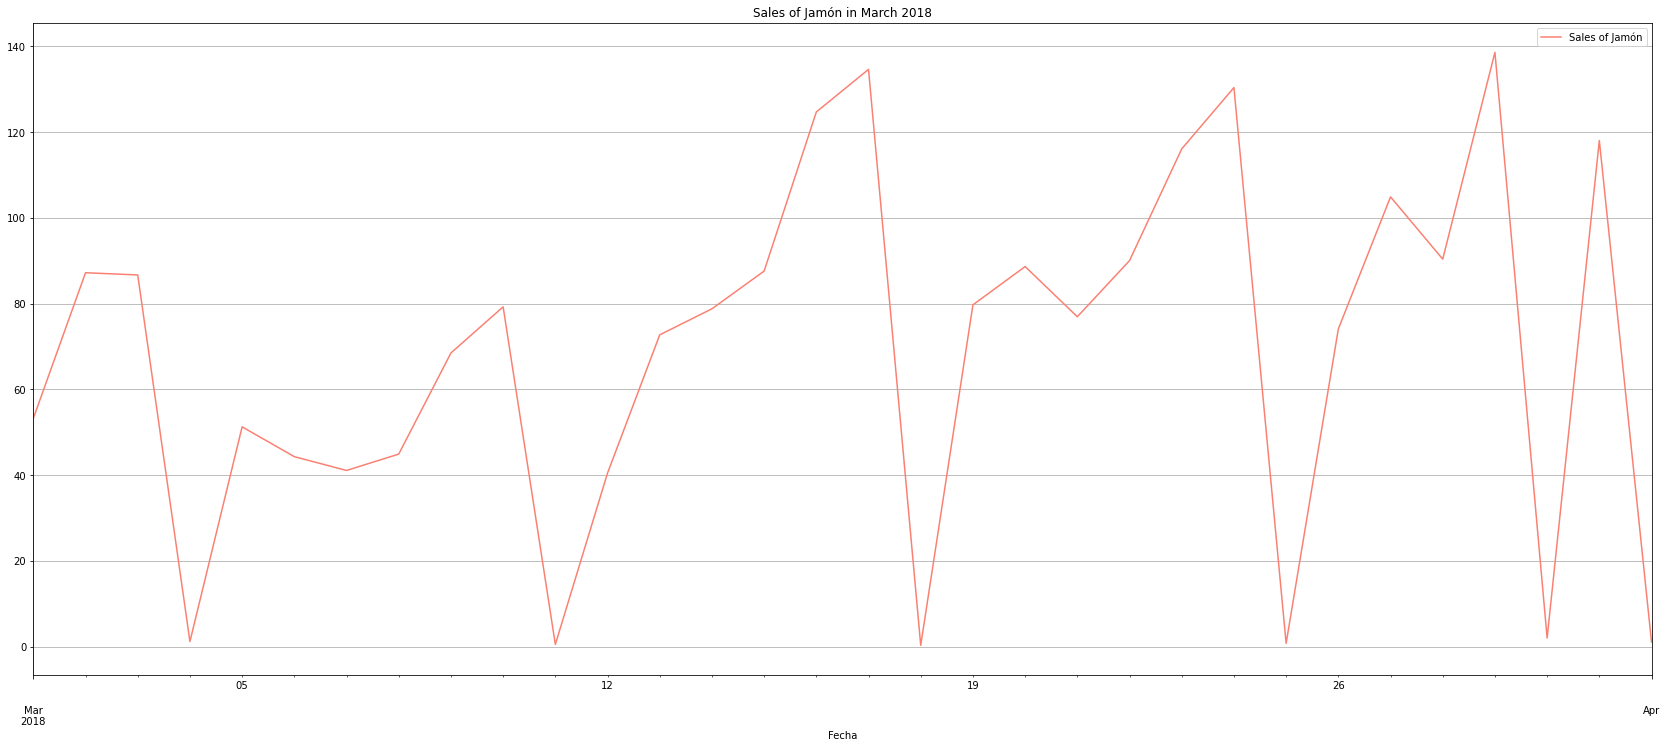

In [424]:
df['Unidades']['2018-03-01':'2018-04-01'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón in March 2018');

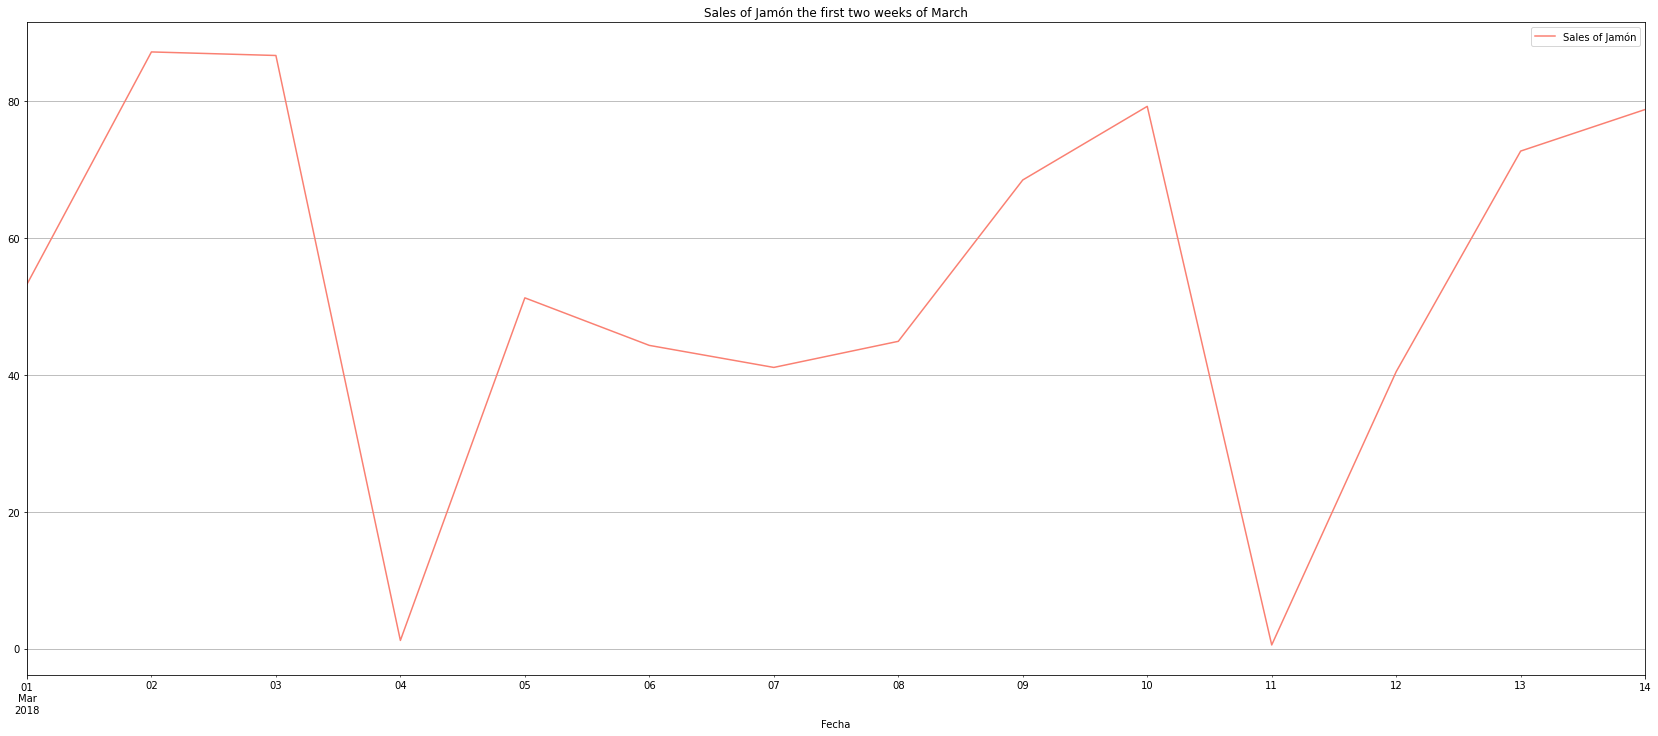

In [425]:
df['Unidades']['2018-03-01':'2018-03-14'].plot(figsize= fig_size,
    color = 'salmon',
    grid = True,
    label = 'Sales of Jamón',
    legend = True,
    title = 'Sales of Jamón the first two weeks of March'); # We can see how we have some stationality at week level. March 4th and March 11th were both Sunday.

In [426]:
df.reset_index(drop = False, inplace = True) # In order to train the model we can't have the date as the index, so we must use integer equally spaced, as the days are in this dataset.
df['OffsetDays'] = df.index

df['day of the week']  = df['Fecha'].dt.dayofweek
df['day of the week'] = df['day of the week'].map({1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 0:'Sunday'})
df = pd.concat([df, pd.get_dummies(df['day of the week'])], axis = 1).\
    drop(['day of the week', 'Fecha', 'Ventas'], axis = 1)

df['Shift_1'] = df['Unidades'].shift(1) # The sales of the day before can alsa be used as
df['Shift_2'] = df['Unidades'].shift(2)
df['Shift_3'] = df['Unidades'].shift(3)
df['Shift_4'] = df['Unidades'].shift(4)
df['Shift_5'] = df['Unidades'].shift(5)
df['Shift_6'] = df['Unidades'].shift(6)
df['Shift_7'] = df['Unidades'].shift(7)

df = df[7:]


In [427]:
df_model = df.copy()
# calculoEvaluacionModelo(SVR(kernel='rbf'), df_model, norma)
calculoEvaluacionModelo(RandomForestRegressor(n_estimators=120, random_state=0), df_model, norma)

Month 759 - Error 0.08742
Month 760 - Error 0.03308
Month 761 - Error 0.02671
Month 762 - Error 0.09461
Month 763 - Error 0.83431
Month 764 - Error 0.50202
Month 765 - Error 0.26500
Month 766 - Error 0.22396
Month 767 - Error 0.23434
Month 768 - Error 0.18636
Month 769 - Error 0.10716
Month 770 - Error 0.04938
Month 771 - Error 0.34525
Month 772 - Error 0.10093
Month 773 - Error 0.04300
Month 774 - Error 0.04759
Month 775 - Error 0.05266
Month 776 - Error 0.37209
Month 777 - Error 0.13499
Month 778 - Error 0.01321
Month 779 - Error 0.36491
Month 780 - Error 0.07529
Month 781 - Error 0.02767
Month 782 - Error 0.16664
Month 783 - Error 0.21665
Month 784 - Error 0.08044
Month 785 - Error 0.25250
Month 786 - Error 0.46296
Month 787 - Error 0.05194
Month 788 - Error 0.03893
Month 789 - Error 0.00198
Month 790 - Error 1.01936
Month 791 - Error 0.03785
Month 792 - Error 0.08271
Month 793 - Error 0.00438
Month 794 - Error 0.07684
Month 795 - Error 0.08133
Month 796 - Error 0.01254
Month 797 - 

[0.08741854597096221,
 0.033079029761823975,
 0.02670542633320583,
 0.09460957787141933,
 0.8343121230242403,
 0.5020178143275373,
 0.26500450384109,
 0.22395973580101458,
 0.23433840259552774,
 0.1863607800756153,
 0.10716114071837435,
 0.04938245944315067,
 0.3452473588722138,
 0.10093273488633026,
 0.042999302950006424,
 0.047592537498349685,
 0.052659139171227665,
 0.37209481952208046,
 0.1349919401605959,
 0.013212672985225105,
 0.36491415206312316,
 0.07529354022642831,
 0.027671244762778713,
 0.16663563351039112,
 0.21664978915668642,
 0.08044022541683482,
 0.25249754568581206,
 0.462960428358016,
 0.05194488704572198,
 0.038934315774681316,
 0.0019845506867675056,
 1.019359531221105,
 0.03784540634979994,
 0.0827115135187606,
 0.00437687928489261,
 0.0768414560656856,
 0.08132591473107009,
 0.012535113181860957,
 0.5985230322240576,
 0.08261859777568681,
 0.03641439498855892,
 0.03280674367511249,
 0.42224628674008535,
 3.4941678870853767,
 0.2500155964610826,
 1.19646062325307